In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

retail_df = pd.read_excel(io = "../../data/Online Retail.xlsx")
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [2]:
retail_df = retail_df[retail_df["Quantity"] > 0]
retail_df = retail_df[retail_df["UnitPrice"] > 0]
retail_df = retail_df[retail_df["CustomerID"].notnull()]
print(retail_df.shape)
print(retail_df.isnull().sum())

(397884, 8)
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [3]:
retail_df["Country"].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [4]:
retail_df = retail_df[retail_df["Country"] == "United Kingdom"]
print(retail_df.shape)

(354321, 8)


In [5]:
retail_df["sale_amount"] = retail_df["Quantity"] * retail_df["UnitPrice"]
retail_df["CustomerID"] = retail_df["CustomerID"].astype(int)

print(retail_df["CustomerID"].value_counts().head(5))
print(retail_df.groupby("CustomerID")["sale_amount"].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [6]:
retail_df.groupby(["InvoiceNo", "StockCode"])["InvoiceNo"].count().mean()

1.028702077315023

In [8]:
# DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
# REcency는 InvoiceDate 칼럼의 max()에서 데이터 가공
# Frequency는 InvoiceNo 카럼의 count(), Monetary value는 sale_amount 칼럼의 sum()
aggregations = {
    "InvoiceDate" : "max",
    "InvoiceNo" : "count",
    "sale_amount" : "sum"
}
cust_df = retail_df.groupby("CustomerID").agg(aggregations)
# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {"InvoiceDate":"Recency",
                                   "InvoiceNo":"Frequency",
                                   "sale_amount":"Monetary"})
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [11]:
import datetime as dt

cust_df["Recency"] = dt.datetime(2011, 12, 10) - cust_df["Recency"]
cust_df["Recency"] = cust_df["Recency"].apply(lambda x : x.days + 1)
print("cust_df 로우와 칼럼 건수는", cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는 (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <a list of 10 Patch objects>)

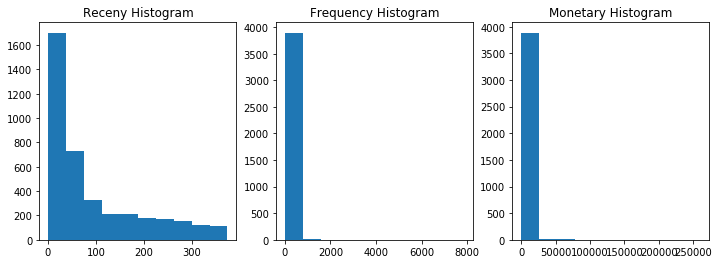

In [19]:
fig, axs = plt.subplots(figsize = (12, 4), nrows = 1, ncols = 3)
axs[0].set_title("Receny Histogram")
axs[0].hist(cust_df["Recency"])

axs[1].set_title("Frequency Histogram")
axs[1].hist(cust_df["Frequency"])

axs[2].set_title("Monetary Histogram")
axs[2].hist(cust_df["Monetary"])

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

x_features = cust_df[["Recency", "Frequency", "Monetary"]].values
x_features_scaled = StandardScaler().fit_transform(x_features)

kmeans = KMeans(n_clusters = 3, random_state = 0)
labels = kmeans.fit_predict(x_features_scaled)
cust_df["cluster_label"] = labels

print("실루엣 스코어는 : {0:.3f}".format(silhouette_score(x_features_scaled, labels)))

실루엣 스코어는 : 0.592
